In [2]:
# region --- PYTHON LIBRARY IMPORTS ---
from math import *
from pathlib import Path
from random import randint
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.pylab as pl
import matplotlib.colors as colors
%matplotlib inline
# --- Spatial geometry ---
from shapely.geometry import Point, Polygon, LineString
# --- Graph theory algorithms ---
from scipy.sparse import csr_matrix
from scipy.sparse.csgraph import minimum_spanning_tree
# --- URBANBEATS LIBRARY IMPORTS ---
#from model.modules.md_delinblocks import *
#import model.ublibs.ubdatatypes as ubdata
# --- SSND IMPORTS ---
from help_functions.helper_functions import verbose_, cm2inch, truncate_colormap
pd.options.mode.chained_assignment = None  # default='warn'

verbose=True

# endregion

In [7]:
# Import networks .csv with hydraulic Design
year_i = 2023
year_f = 2038
year_step = 5 

netwroks_dict = dict()
for year in range(year_i, year_f+1, year_step): 
    filename = fr"C:\Users\duquevna\Dropbox\010_PhD\01_Python\SND_Manual\Data\data\USTER\output\csv\HD_USTER_200_({year}).csv"
    network = gpd.read_file(filename)
    #network = network.set_crs('epsg:2056') # Projection  EPSG:2056  "CH1903+ / LV95"
    # list(network.columns[:25])

    netwroks_dict[year] = network
netwroks_dict

{2023:     id_up id_down type             design_flow basin    LinkType  \
 0     200     239    2   2.564452288048098e-05     0       Trunk   
 1     201     200    1  1.2436775439478072e-05     1  Collection   
 2     228     270    1   3.700381839819595e-05     3  Collection   
 3     230     270    1      0.0003538083795609     3  Collection   
 4     239     403    2  3.5809362511858906e-05     0       Trunk   
 ..    ...     ...  ...                     ...   ...         ...   
 291  1381    1340    1      0.0014417510641056    41  Collection   
 292  1409    1325    2      0.0086597835512978     0       Trunk   
 293  1410    1409    1      0.0014762655193955    42  Collection   
 294  1411    1453    1      0.0014491970747583    43  Collection   
 295  1453    1409    2      0.0058620039302385     0       Trunk   
 
                  up_ids                                           down_ids  \
 0                 [201]  [239, 403, 568, 562, 603, 602, 518, 517, 435, ...   
 1    

In [9]:
# Import Blocks .shp files from UB into a doctionary with geopandas dataframe for every year
year_i = 2023
year_f = 2038
year_step = 5 

blocks_dict = dict()
for year in range(year_i, year_f+1, year_step): 
    filename = fr"C:\Users\duquevna\Dropbox\010_PhD\06_Results\Uster\USTER\output\200_({str(year)})_Blocks.shp"
    blocks = gpd.read_file(filename)
    #network = network.set_crs('epsg:2056') # Projection  EPSG:2056  "CH1903+ / LV95"
    # list(network.columns[:25])

    blocks_dict[year] = blocks
blocks_dict

{2023:       BlockID BasinID  CentreX  CentreY                Neighbours  Active  \
 0          16    None   3100.0    100.0               17,56,57,58    0.75   
 1          17    None   3300.0    100.0            16,18,57,58,59    1.00   
 2          18    None   3500.0    100.0                  17,58,59    0.75   
 3          22    None   4300.0    100.0               23,62,63,64    0.25   
 4          23    None   4500.0    100.0            22,24,63,64,65    1.00   
 ...       ...     ...      ...      ...                       ...     ...   
 1051     1424    None   5900.0   6900.0  1382,1383,1384,1423,1425    1.00   
 1052     1425    None   6100.0   6900.0       1383,1384,1385,1424    0.25   
 1053     1453    None   3500.0   7100.0       1411,1412,1413,1454    1.00   
 1054     1454    None   3700.0   7100.0  1412,1413,1414,1453,1455    1.00   
 1055     1455    None   3900.0   7100.0       1413,1414,1415,1454    0.50   
 
       pLU_RES  pLU_COM  pLU_ORC  pLU_LI  ...   Blk_Loss

In [81]:
year=2038
network = netwroks_dict[year]
blocks = blocks_dict[year]
print(len(network) )
print(len(blocks[blocks["HasSWW"]==1]))


410
411


In [82]:
blocks[blocks["HasSWW"]==1]

BlockID BasinID  CentreX  CentreY                       Neighbours  \
62        159    None   7100.0    700.0  117,118,119,158,160,199,200,201   
86        198    None   6700.0    900.0  156,157,158,197,199,238,239,240   
87        199    None   6900.0    900.0  157,158,159,198,200,239,240,241   
88        200    None   7100.0    900.0  158,159,160,199,201,240,241,242   
89        201    None   7300.0    900.0  159,160,161,200,202,241,242,243   
...       ...     ...      ...      ...                              ...   
1037     1381    None   5500.0   6700.0    1339,1340,1341,1382,1422,1423   
1042     1409    None   2900.0   6900.0              1367,1368,1369,1410   
1043     1410    None   3100.0   6900.0         1368,1369,1370,1409,1411   
1044     1411    None   3300.0   6900.0    1369,1370,1371,1410,1412,1453   
1053     1453    None   3500.0   7100.0              1411,1412,1413,1454   

      Active  pLU_RES  pLU_COM  pLU_ORC    pLU_LI  ...   Blk_Loss  HasSWW  \
62      1.00     0.50      0.0      0.0  0.000000  ...   0.260113     1.0   
86      1.00     0.25      0.0      0.0  0.000000  ...   0.103814     1.0   
87      1.00     0.50      0.0      0.0  0.000000  ...   0.276754     1.0   
88      1.00     1.00      0.0      0.0  0.000000  ...   0.603496     1.0   
89      1.00     0.25      0.0      0.0  0.000000  ...   0.237491     1.0   
...      ...      ...      ...      ...       ...  ...        ...     ...   
1037    0.50     0.00      0.0      0.0  0.500000  ...   1.840298     1.0   
1042    0.50     0.00      0.0      0.5  0.000000  ...   3.355358     1.0   
1043    0.50     0.00      0.0      0.0  1.000000  ...   3.739669     1.0   
1044    0.75     0.00      0.0      0.0  0.666667  ...   3.629525     1.0   
1053    1.00     0.00      0.0      0.5  0.500000  ...  10.749055     1.0   

      HasWWTP  HasCarved  Sww_down_i  ModAvgElev  DEM_sink  SwwType  DesgFlow  \
62        0.0        1.0        None  492.390625        -1        2  0.000276   
86        0.0       -1.0        None  486.250000         0        2  0.000574   
87        0.0       -1.0        None  493.812500         0        2  0.000173   
88        0.0       -1.0        None  505.609375         0        1  0.000133   
89        0.0       -1.0        None  518.125000         0        1  0.000078   
...       ...        ...         ...         ...       ...      ...       ...   
1037      0.0       -1.0        None  536.800000         0        1  0.000693   
1042      0.0       -1.0        None  471.222222         0        2  0.036927   
1043      0.0       -1.0        None  473.875000         0        1  0.001405   
1044      0.0       -1.0        None  478.300000         0        1  0.001363   
1053      0.0        1.0        None  472.000000        -1        2  0.034245   

                                               geometry  
62    POLYGON ((2698695.220 1242442.898, 2698695.220...  
86    POLYGON ((2698295.220 1242642.898, 2698295.220...  
87    POLYGON ((2698495.220 1242642.898, 2698495.220...  
88    POLYGON ((2698695.220 1242642.898, 2698695.220...  
89    POLYGON ((2698895.220 1242642.898, 2698895.220...  
...                                                 ...  
1037  POLYGON ((2697095.220 1248442.898, 2697095.220...  
1042  POLYGON ((2694495.220 1248642.898, 2694495.220...  
1043  POLYGON ((2694695.220 1248642.898, 2694695.220...  
1044  POLYGON ((2694895.220 1248642.898, 2694895.220...  
1053  POLYGON ((2695095.220 1248842.898, 2695095.220...  

[411 rows x 182 columns]

In [83]:
blocks_sww = blocks[blocks["HasSWW"]==1].copy()

list_geometries = []

for i, block in network.iterrows():
    
    up_id = int(network.loc[i, "id_up"])
    down_id = int(network.loc[i, "id_down"])
    print(up_id, down_id)

    # create line from A to B 
    point_A = blocks_sww[blocks_sww["BlockID"]==up_id].centroid
    point_B = blocks_sww[blocks_sww["BlockID"]==down_id].centroid

    print(point_A, "\n" , point_B)

    list_geometries.append(LineString([(point_A.x, point_A.y), (point_B.x, point_B.y)]))

network.set_geometry(list_geometries, inplace=True, crs=blocks.crs)
# update dictionary of dataframes
netwroks_dict[year]=network

#create shapefile
filename = fr"C:\Users\duquevna\Dropbox\010_PhD\01_Python\SND_Manual\Data\data\USTER\output\csv\HD_USTER_200_({year})(2)"
network.to_file(filename, crs=blocks.crs)

159 198
62    POINT (2698795.220 1242542.898)
dtype: geometry 
 86    POINT (2698395.220 1242742.898)
dtype: geometry
198 568
86    POINT (2698395.220 1242742.898)
dtype: geometry 
 353    POINT (2698595.220 1244542.898)
dtype: geometry
199 198
87    POINT (2698595.220 1242742.898)
dtype: geometry 
 86    POINT (2698395.220 1242742.898)
dtype: geometry
200 159
88    POINT (2698795.220 1242742.898)
dtype: geometry 
 62    POINT (2698795.220 1242542.898)
dtype: geometry
201 159
89    POINT (2698995.220 1242742.898)
dtype: geometry 
 62    POINT (2698795.220 1242542.898)
dtype: geometry
202 159
90    POINT (2699195.220 1242742.898)
dtype: geometry 
 62    POINT (2698795.220 1242542.898)
dtype: geometry
228 270
102    POINT (2696195.220 1242942.898)
dtype: geometry 
 131    POINT (2696395.220 1243142.898)
dtype: geometry
229 270
103    POINT (2696395.220 1242942.898)
dtype: geometry 
 131    POINT (2696395.220 1243142.898)
dtype: geometry
230 270
104    POINT (2696595.220 1242942.898)
dtyp

c:\Users\duquevna\Anaconda3.10\envs\py39\lib\site-packages\geopandas\io\file.py:299: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
C:\Users\duquevna\AppData\Local\Temp\ipykernel_46916\1930802582.py:25: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  network.to_file(filename, crs=blocks.crs)


In [65]:
# Reading this shapefile migth modify the names of the columns to 10_characters
# filename = fr"C:\Users\duquevna\Dropbox\010_PhD\01_Python\SND_Manual\Data\data\USTER\output\csv\HD_USTER_200_(2023)(2)\HD_USTER_200_(2023)(2).shp"
# network = gpd.read_file(filename)

In [66]:
cmap_lake = truncate_colormap(cmap=pl.cm.Blues, minval=0.5)
cmap_river = truncate_colormap(cmap=pl.cm.Blues, minval=0.3)
cmap_earth = truncate_colormap(pl.cm.gist_earth, minval=0.2)

cmap_HasSww= truncate_colormap(cmap=pl.cm.YlOrRd, minval=0.2)
cmap_pop = truncate_colormap(cmap=pl.cm.Reds, minval=0.2, maxval=0.7)
cmap_luc = truncate_colormap(cmap=pl.cm.Pastel2, minval=0.2, maxval=0.7) # [TODO]

cmap_flow = truncate_colormap(cmap=pl.cm.Blues, minval=0.0, maxval=1.0)

In [16]:
from help_functions.helper_functions import cm2inch, verbose_
## Plot FEATURE Delevopment
cmap_feature1 = cmap=pl.cm.YlOrRd

def Plot_FEATURE_delevopment (networks_dict, feature_name = "HasSWW", feature_units = "", cmap= cmap_feature1):
    """"Plot the delevopment over time of a specific feature

        :param feature_name = "HasSWW"         # name of the feature as it is in the input data
        :param feature_units = ""              # [SI units]
        :param cmap_feature1 = truncate_colormap(cmap=pl.cm.YlOrRd, minval=0.0, maxval=0.2)
        :return figure
    """
    
    years = list(networks_dict.keys())
    min_values = []
    max_values = []
    for i, year in enumerate(years): 
        feature_series = networks_dict[year][f'{feature_name}']

        min_values.append(min(feature_series))
        max_values.append(max(feature_series))
        
    vmin = min(min_values)
    vmax = max(max_values)

    fig, axs = plt.subplots(1, len(years), figsize=cm2inch(90, 180)) 

    for i, year in enumerate(years): 
        ax = axs[i]
        blocks_dict[year].plot(ax=ax, color="none", edgecolor='lightgrey')
        blocks_dict[year].replace(0, np.nan).plot(column="HasLake",ax=ax, cmap=cmap_lake, edgecolor='none')
        networks_dict[year].replace(0, np.nan).plot(column=f'{feature_name}', ax = ax, cmap=cmap, alpha= 0.9, legend=False, 
                # label= f'{feature_name} {feature_units}',
                # linestyle="-", marker="o", markersize=10, markerfacecolor="k", markeredgewidth=0,
                # legend_kwds={"fmt": "{:.0f}", 'orientation' : 'horizontal', 'shrink': 0.50, 'anchor':(0.5, 2), 'label': f'{feature_name} {feature_units}'},
                # missing_kwds={'alpha': 0.0},
                )
        # North Arrow       
        x, y, arrow_length = 0.9, 1.0, 0.1
        ax.annotate('N', xy=(x, y), xytext=(x, y-arrow_length),
                arrowprops=dict(facecolor='black', width=3, headwidth=9),
                ha='center', va='center', fontsize=14,
                xycoords=ax.transAxes)
        ax.set_title(f"{year}")
        ax.axis("off")

    plt.show()      
    return None


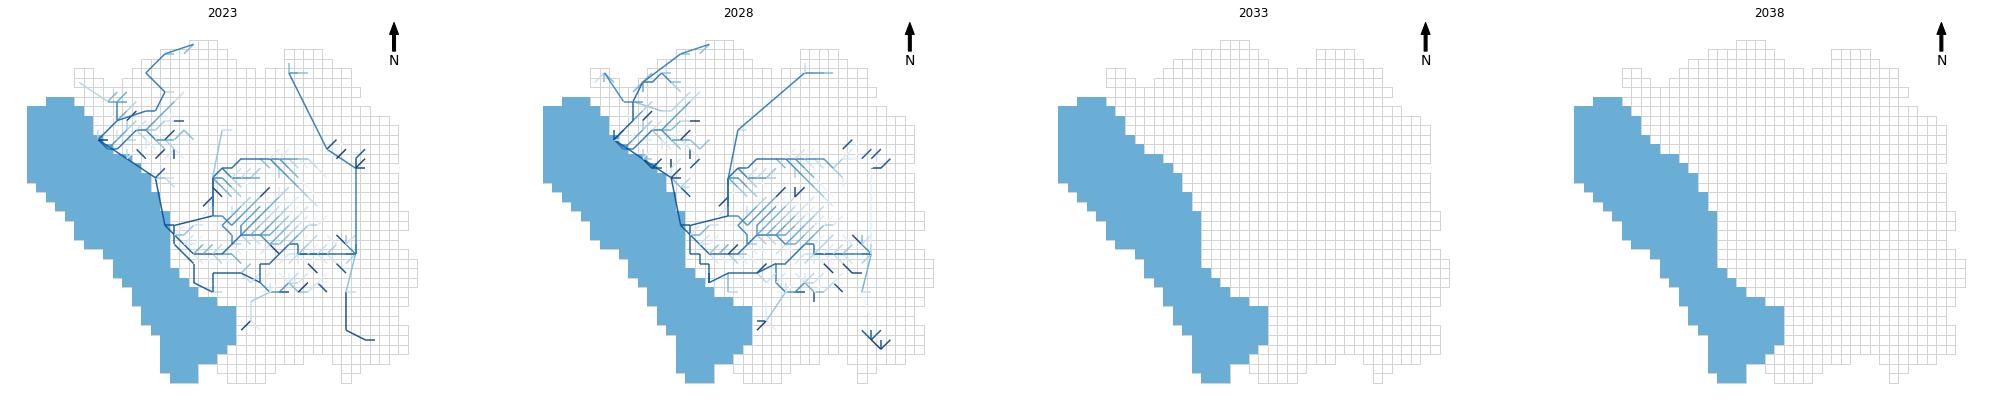

In [45]:
Plot_FEATURE_delevopment(networks_dict=netwroks_dict, feature_name="design_flow", feature_units="m3/s",cmap=pl.cm.Blues)

In [46]:
network.columns

Index(['id_up', 'id_down', 'type', 'design_flow', 'basin', 'LinkType',
       'up_ids', 'down_ids', 'length', 'terrain_slope', 'diameter', 'slope',
       'tElev_up', 'tElev_down', 'up_elevation', 'down_elevation', 'up_depth',
       'down_depth', 'avg_depth', 'pump', 'drop', 'exact_flow',
       'filling_ratio', 'normal_depth', 'angle', 'h_radius', 'area',
       'velocity', 'froude', 'tau', 'from_up_mh', 'geometry'],
      dtype='object')

(2692475.219529456, 2699515.219529456, 1242222.8984727913, 1249262.8984727913)

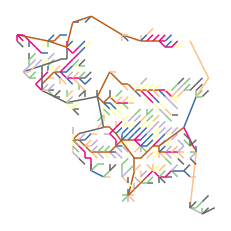

In [84]:
network.plot(column="design_flow", cmap = pl.cm.Accent, )
plt.axis("off")

In [68]:
network.columns

Index(['id_up', 'id_down', 'type', 'design_flow', 'basin', 'LinkType',
       'up_ids', 'down_ids', 'length', 'terrain_slope', 'diameter', 'slope',
       'tElev_up', 'tElev_down', 'up_elevation', 'down_elevation', 'up_depth',
       'down_depth', 'avg_depth', 'pump', 'drop', 'exact_flow',
       'filling_ratio', 'normal_depth', 'angle', 'h_radius', 'area',
       'velocity', 'froude', 'tau', 'from_up_mh', 'geometry'],
      dtype='object')

In [85]:
# Calculate MAX_FILLING_RATIO given the diameters of the pipes
for idx, diameter in network["diameter"].iteritems():
    # Maximum filling ratio in general
    diameter= float(diameter)
    
    if diameter <= 0.6:
        mfr = 0.7
    elif 0.6 < diameter <= 1.5:
        mfr = 0.8
    elif diameter > 1.5:
        mfr = 0.85
    network.loc[idx, "max_fill_ratio"] = mfr

In [86]:
# Calculate MAX_FLOW_DEPTH 
for idx, diameter in network["diameter"].iteritems():
    # Maximum filling ratio in general
    diameter= float(diameter)
    
    network.loc[idx, "max_y"] = network.loc[idx, "max_fill_ratio"] * diameter

In [87]:
# Calculate MAX_ANGLE 
for idx, diameter in network["diameter"].iteritems():
    # Maximum filling ratio in general
    diameter= float(diameter)
    y = network.loc[idx, "max_y"]
    network.loc[idx, "max_angle"] = 2 * np.arccos(1 - 2 * y / diameter)

In [88]:
# Calculate MAX_WETTED_PERIMETER 
for idx, diameter in network["diameter"].iteritems():
    # Maximum filling ratio in general
    diameter= float(diameter)
    angle = network.loc[idx, "max_angle"]
    network.loc[idx, "max_P"] = angle * diameter / 2

In [89]:
# Calculate MAX_HYDRAULIC_RADIUS
for idx, diameter in network["diameter"].iteritems():
    # Maximum filling ratio in general
    diameter= float(diameter)
    angle = network.loc[idx, "max_angle"]
    network.loc[idx, "max_R"] = (diameter / 4) * (1 - np.sin(angle) / angle)

In [90]:
# Calculate MAX_AREA
for idx, diameter in network["diameter"].iteritems():
    # Maximum filling ratio in general
    diameter= float(diameter)
    angle = network.loc[idx, "max_angle"]
    network.loc[idx, "max_A"] = (np.power(diameter, 2) / 8) * (angle - np.sin(angle))

In [91]:
# Calculate MAX_VELOCITY
for idx, diameter in network["diameter"].iteritems():
    # Maximum filling ratio in general
    diameter= float(diameter)
    radius = float(network.loc[idx, "max_R"])
   
    area = float(network.loc[idx, "max_A"])
    slope = float(network.loc[idx, "slope"])
   
    n=0.009 # for PVC [Source: Butler and Davies(2011), Urban Drainage]
    network.loc[idx, "max_FLOW"] = area / n * np.power(radius, (2.0 / 3)) * np.sqrt(slope)

In [92]:
# Calculate UNDERCAPACITY and OVER CAPACITY

total_flow = sum (network["max_FLOW"])
for idx, diameter in network["diameter"].iteritems():
    # Maximum filling ratio in general
    diameter= float(diameter)
    design_flow = float(network.loc[idx, "design_flow"])
    max_FLOW = float(network.loc[idx, "max_FLOW"])
   
    n=0.009 # for PVC [Source: Butler and Davies(2011), Urban Drainage]
    capacity_gap = 1-(design_flow/max_FLOW)
    network.loc[idx, "capacity_gap"] = capacity_gap

    if capacity_gap < 0 : 
        print("ENTRO.. UNDERCAPACITY")
        network.loc[idx, "undercapacity"] = capacity_gap * (design_flow/total_flow)
        network.loc[idx, "overcapacity"] = 0

    else:
        network.loc[idx, "undercapacity"] = 0
        network.loc[idx, "overcapacity"] = capacity_gap * (design_flow/total_flow)


In [93]:
def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

In [94]:
network.loc[:, ("design_flow", "undercapacity", "overcapacity")]

design_flow  undercapacity  overcapacity
0       0.0002763539561034            0.0      0.000008
1         0.00057357371044            0.0      0.000017
2       0.0001731080952777            0.0      0.000005
3       0.0001330574619803            0.0      0.000004
4    7.760784366373903e-05            0.0      0.000002
..                     ...            ...           ...
405       0.00069304959352            0.0      0.000021
406      0.036926892196422            0.0      0.001073
407     0.0014052927664347            0.0      0.000042
408     0.0013630760788044            0.0      0.000041
409     0.0342448268805734            0.0      0.000999

[410 rows x 3 columns]

In [95]:
float(network.loc[0,"design_flow"])

0.0002763539561034

In [96]:

sum(network["overcapacity"])

0.051198715900926964

In [97]:
sum(network["undercapacity"])

0.0